In [11]:
import pandas as pd

import _background as bg
import molNet
from molNet.dataloader.molecule_loader import PytorchGeomMolDfLoader
from molNet.featurizer.atom_featurizer import atom_formal_charge, atom_partial_charge, atom_hybridization_one_hot, \
    atom_is_aromatic, atom_is_in_ring, atom_symbol_one_hot_from_set, atom_total_degree_one_hot, atom_chiral_tag_one_hot, atom_total_num_H_one_hot
from molNet.featurizer.featurizer import FeaturizerList
import pytorch_lightning as pl
import torch
import numpy as np

In [15]:
MAX_DS_LENGTH_FAC=1

tasks=[
    #["smiles","measured log solubility in mols per litre",],
    #["smiles","exp"],
    #["smiles","expt"],
    #["smiles","mpC"],
    ["smiles", "mu", "alpha", "homo", "lumo", "gap", "r2", "zpve", "cv", "u0", "u298",
    "h298", "g298","u0_atom","u298_atom","h298_atom","g298_atom"],
]

files=[
   # "data/delaney-processed.csv",
   # "data/Lipophilicity.csv",
   # "data/SAMPL.csv",
   # "data/patents_ochem_enamine_bradley_begstrom_training_edit.csv",
    "data/qm9.csv",
]

datasets = [
    pd.read_csv(f) for f in files
]

datasets = [
    ds[[tasks[i][0],tasks[i][j]]] for i,ds in enumerate(datasets) for j in range(1,len(tasks[i])) 
]

tasks=[t[j] for t in tasks for j in range(1,len(t)) ]

max_length=MAX_DS_LENGTH_FAC * min(len(ds) for ds in datasets)
max_length=1000
datasets=[ds if len(ds)<=max_length else ds.sample(max_length) for ds in datasets]
for ds in datasets:
    ds["task_id"]=tasks.index(list(ds.columns)[1])

In [16]:
normination=np.array([[ds[tasks[i]].min(),ds[tasks[i]].max()-ds[tasks[i]].min()] for i,ds in enumerate(datasets)])

In [17]:
datasets=[ds.rename({tasks[i]:"value"},axis=1) for i,ds in enumerate(datasets)]
datasets[0]

,smiles,value,task_id
121411,COCC1OCCCO1,1.5176,0
116921,CN1CC1C#CCCO,1.0189,0
85105,CC1OC(=N)C1(O)C#N,3.6102,0
118905,COCC1(O)CC=CC1,2.0696,0
82412,CC1N2CC2CCC1=O,2.1730,0
...,...,...,...
80589,CC1C2OC(C12)C(N)=O,2.8201,0
6437,CC1CC(C)(C1)C#N,4.0472,0
25562,c1cc(oc1)CCC=O,2.6397,0
58776,CC(C)C12CC1(O)CO2,1.9811,0


In [18]:
dataset=pd.concat(datasets)

In [19]:
dataset

,smiles,value,task_id
121411,COCC1OCCCO1,1.517600,0
116921,CN1CC1C#CCCO,1.018900,0
85105,CC1OC(=N)C1(O)C#N,3.610200,0
118905,COCC1(O)CC=CC1,2.069600,0
82412,CC1N2CC2CCC1=O,2.173000,0
...,...,...,...
77042,CC1C(CC#C)OC1=N,-1661.506408,15
6706,CC(C)OCCC#N,-1663.158639,15
110080,COC1C(C=O)C1C#C,-1587.247620,15
97867,CCC#CCC#CC#N,-1599.128248,15


In [20]:
((dataset["value"]-normination[dataset["task_id"]][:,0])/normination[dataset["task_id"]][:,1])

121411    0.099688
116921    0.066383
85105     0.239440
118905    0.136553
82412     0.143458
            ...   
77042     0.436751
6706      0.435609
110080    0.488057
97867     0.479848
43463     0.503217
Name: value, Length: 16000, dtype: float64

In [21]:
#dataset["rd_mol"]=dataset["smiles"].apply(bg.MolFromSmiles)
#c_mp_atom_symbol_featurizer = atom_symbol_one_hot_from_set(dataset["rd_mol"],only_mass=True)

from molNet.featurizer.featurizer import OneHotFeaturizer
def _get_atom_symbol(atom):
    return atom.GetSymbol()
c_mp_atom_symbol_featurizer = OneHotFeaturizer(
    possible_values=['O', 'Si', 'Na', 'H', 'P', 'F', 'S', 'C', 'Cl', 'N', 'B', 'Br','I',None],
    pre_featurize=_get_atom_symbol,
    name="atom_symbol_one_hot",
)

featurizer = FeaturizerList([
    c_mp_atom_symbol_featurizer,
    atom_total_degree_one_hot,
    atom_formal_charge,
    atom_partial_charge,
    atom_chiral_tag_one_hot,
    #atom_total_num_H_one_hot,
    atom_hybridization_one_hot,
    atom_is_aromatic,
    atom_is_in_ring,
])

In [22]:
loader_MultiTaskMNodel1 = PytorchGeomMolDfLoader(dataset,
                                         y_columns=["value"],
                                         columns=["task_id"],
                                         atom_featurizer=featurizer,
                                         inplace=True,
                                         seed=2,
                                         batch_size=512,
                                         to_graph_input_kwargs=dict(
                                            # with_mol_graph=True
                                         ),
                                    #        worker=1,
                                     #       path="test/qm9.pckl"
                                            
                               )

In [23]:
loader_MultiTaskMNodel1.setup()
for batch in loader_MultiTaskMNodel1.train_dataloader():
    print(batch)
    break

Batch(batch=[9298], edge_index=[2, 19174], x=[9298, 38], x_graph_features=[512, 1], y=[9298, 0], y_graph_features=[512, 1])


In [24]:
import copy
class MultiModel(bg.ChemGCModel):
    def __init__(self,n_tasks=1,normalization=None,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.n=n_tasks
        self.lr=0.01
        self.bs=[0 for i in range(self.n)]
        self.nns=torch.nn.ModuleList([copy.deepcopy(self.nn) for _ in range(self.n)])
        self.set_task(0)
        
        if normalization is None:
            normalization=[[0,1] for _ in range(self.n)]
        self.task_normalization=torch.Tensor(normalization)
        #print(self.task_normalization.shape)
        #print(self.task_normalization)
    
    def set_task(self,idx):
        #self.nn.requires_grad = False
        self.nn=self.nns[idx]
        #self.nn.requires_grad = True
        self.task=idx
    
    def batch_to_loss(self,batch):
        n=self.task_normalization[self.task]
        y_hat=self(batch)
        #print(y_hat,n[0],n[1])
        y_hat=(y_hat-n[0])/n[1]
        y_norm=(batch.y_graph_features-n[0])/n[1]
        loss = self.lossf(y_hat, y_norm)
        return loss
    
        
        
    def extract_task_batch(self,batch,idx):
        self.set_task(idx)
        task_ids=batch.x_graph_features[:,0].int()
        dl=batch.to_data_list()
        dl=[d for i,d in enumerate(dl) if task_ids[i]==idx]
        batch=batch.__class__.from_data_list(dl)
        #batch.to(self.device)
        return batch
        
    def training_step(self,batch,batch_idx,*args,**kwargs):
        idx = self.current_epoch%self.n
        n_batch=self.extract_task_batch(batch,idx)
        loss = self.batch_to_loss(n_batch)
        print(loss)
        self.set_task(0)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self,batch,batch_idx,*args,**kwargs):
        idx = self.current_epoch%self.n
        n_batch=self.extract_task_batch(batch,idx)
        loss = self.batch_to_loss(n_batch)
        print(loss)
        self.set_task(0)
        self.log('val_loss', loss)
        return loss
    
    def test_step(self,batch,batch_idx,*args,**kwargs):
        losses=None
        for idx in range(self.n):
            n_batch=self.extract_task_batch(batch,idx)
            loss = self.batch_to_loss(n_batch)
            if losses is None:
                losses=loss
            else:
                losses+=loss
        losses/=self.n
        self.log('test_loss', loss)
        return loss
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        self.nns.to(self.device)
        return optimizer

In [25]:
model_MultiTaskMNodel1=MultiModel(
    n_tasks=len(tasks),
    in_size=len(featurizer),
    out_size=1,
    normalization=normination,
    post_pool_norm=True,
    
    n_chem_layer = 10,
    chem_layer_feats_out=64,
    chem_layer_gc_out=32,
    chem_layer_net_sizes=32,
    chem_layer_net_count=2,
    collector_net_depth=6,
    collector_net_depth_red_fac=2,
    poolings=["pool_min","pool_max","pool_mean","pool_nwsum","pool_wsum"],
    lr=0.001,
    lossf=torch.nn.RMSELoss(),
    dropout=0.15
)

train_loss tensor(0.1673, device='cuda:0') val_loss tensor(0.1410, device='cuda:0') 


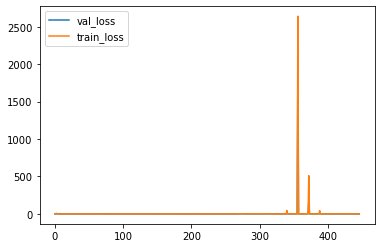

Epoch 446, step 9833: val_loss was not in top 1
INFO:lightning:Epoch 446, step 9833: val_loss was not in top 1


tensor(1.2436, device='cuda:0', grad_fn=<SqrtBackward>)
tensor(1.0544, device='cuda:0', grad_fn=<SqrtBackward>)
tensor(0.7565, device='cuda:0', grad_fn=<SqrtBackward>)
tensor(0.3951, device='cuda:0', grad_fn=<SqrtBackward>)
tensor(0.1747, device='cuda:0', grad_fn=<SqrtBackward>)
tensor(0.2516, device='cuda:0', grad_fn=<SqrtBackward>)
tensor(0.4325, device='cuda:0', grad_fn=<SqrtBackward>)
tensor(0.4788, device='cuda:0', grad_fn=<SqrtBackward>)


In [ ]:
model_MultiTaskMNodel1,dat_MultiTaskMNodel1 = bg.default_model_run(
        "MultiTaskMNodel1",
        model_MultiTaskMNodel1,
        loader_MultiTaskMNodel1,
                      force_run=True,
                      #force_test_data_reload=True,
                    #min_epochs=200,
                    early_stopping=True,
                    max_epochs=5000,
                    early_stopping_delta=0.0,
                   detect_lr=False,
                    early_stop_patience=500,
    )

In [22]:
model_MultiTaskMNodel1

MultiModel(
  (chem_layer): Sequential(
    (0): ChemGCLayer(
      (fcnn): Sequential(
        (0): Linear(in_features=38, out_features=32, bias=True)
        (1): ELU(alpha=1.0)
        (2): Linear(in_features=32, out_features=32, bias=True)
        (3): ELU(alpha=1.0)
      )
      (gc): GCNConv(70, 32)
      (combine): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): ELU(alpha=1.0)
      )
    )
    (1): ChemGCLayer(
      (fcnn): Sequential(
        (0): Linear(in_features=102, out_features=32, bias=True)
        (1): Dropout(p=0.15, inplace=False)
        (2): ELU(alpha=1.0)
        (3): Linear(in_features=32, out_features=32, bias=True)
        (4): Dropout(p=0.15, inplace=False)
        (5): ELU(alpha=1.0)
      )
      (gc): GCNConv(134, 32)
      (combine): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): Dropout(p=0.15, inplace=False)
        (2): ELU(alpha=1.0)
      )
    )
    (2): ChemGCLayer

In [34]:
true=[]
pred=[]
try:
    loader_MultiTaskMNodel1.train_dataloader()
except:
    loader_MultiTaskMNodel1.setup()
    
for l in [
        #loader_MultiTaskMNodel1.train_dataloader(),
        #  loader_MultiTaskMNodel1.val_dataloader(),
          loader_MultiTaskMNodel1.test_dataloader()
         ]:
    for d in l:
        for i in range(len(tasks)):
            n_batch=model_MultiTaskMNodel1.extract_task_batch(d,i)
            pred.extend(((model_MultiTaskMNodel1(n_batch).detach().numpy()-normination[i][0])/normination[i][1]).tolist())
            true.extend(((n_batch.y_graph_features.numpy()-normination[i][0])/normination[i][1]).tolist())
        
    #print(()-np.exp(d.y.numpy())).mean())

pred=np.array(pred)
true=np.array(true)

In [35]:
pred.shape

(1926, 1)

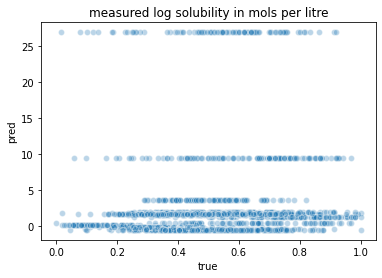

6.335609449154021 2.786555586713497


In [40]:
import matplotlib.pyplot as plt


rp=[]
rt=[]
for i in range(pred.shape[1]):
    task=tasks[i]
    t=true[:,i]#*scalef[task][1]+scalef[task][0]
    p=pred[:,i]#*scalef[task][1]+scalef[task][0]
    rp.append(p)
    rt.append(t)
    dmin=min(t.min(),p.min())
    dmax=max(t.max(),p.max())
    #plt.hexbin(t,p,gridsize=40)
    #plt.plot([dmin,dmax],[dmin,dmax],"--r",alpha=0.75)
    plt.plot(true,pred,"o",alpha=0.3,markeredgecolor="w")
    plt.xlabel("true")
    plt.ylabel("pred")
    plt.title(task)
    plt.show()
    plt.close()
    print(np.sqrt((np.abs(p-t)**2).mean()),np.abs(p-t).mean())
#plt.plot(np.exp(pred),np.exp(true),"o")
#plt.show()
#plt.close()

In [ ]:
#print(np.abs(np.exp(pred)-np.exp(true)).mean())
import datetime
np.sqrt((np.abs(np.concatenate(rp)-np.concatenate(rt))**2).mean()),np.abs(np.concatenate(rp)-np.concatenate(rt)).mean(),datetime.datetime.now()

In [ ]:
import numpy as np
ysa=np.array(ys)

In [ ]:
import optuna
study = optuna.create_study(study_name="aaa",
                            direction="minimize",
                           )